# RFA Proyect
Training MLP models over Diabetic_Retinopathy dataset steps 1:
- 1.0 Preprocess
- 1.1 Basic Perceptron model
- 1.2 Study of MLP Architecture

## 1.0 Preprocess


In [2]:
! pip install keras_tuner
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import keras
import keras_tuner

keras.utils.set_random_seed(23)
import tensorflow as tf
import numpy as np

!export TF_CUDNN_WORKSPACE_LIMIT_IN_MB=1024
from datasets import load_dataset, DatasetDict, ClassLabel

In [20]:
def prepare_inputs(image_label):
    image = tf.cast(image_label["image"], tf.uint8)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, (-1,))
    return (image, tf.keras.utils.to_categorical(image_label["label"], num_classes=5))


ds = load_dataset("Rami/Diabetic_Retinopathy_Preprocessed_Dataset_256x256").shuffle(
    seed=23
)
ds = ds.cast_column(
    "label",
    ClassLabel(
        names=["Healthy", "Moderate DR", "Mild DR", "Proliferate DR", "Severe DR"]
    ),
)
ds = (
    ds["train"].to_tf_dataset().map(prepare_inputs, num_parallel_calls=tf.data.AUTOTUNE)
)
trainval, test = keras.utils.split_dataset(ds, right_size=0.20)
train, val = keras.utils.split_dataset(trainval, right_size=0.20)

In [21]:
ds_train = train.cache()
ds_train = ds_train.shuffle(buffer_size=1000)
ds_train = ds_train.batch(128)
train_dataset = ds_train.prefetch(tf.data.AUTOTUNE)
ds_val = val.batch(128)
ds_val = ds_val.cache()
val_dataset = ds_val.prefetch(tf.data.AUTOTUNE)
ds_test = test.batch(128)
ds_test = ds_test.cache()
test_dataset = ds_test.prefetch(tf.data.AUTOTUNE)

In [22]:
for e in train_dataset.take(1):
    print(f"After preprocesss Image type {type(e[0])}")
    print(f"After preprocesss Input shape: {e[0].shape}")
    input_dim = tuple(e[0].shape.as_list()[1:])
    num_classes = 5

After preprocesss Image type <class 'tensorflow.python.framework.ops.EagerTensor'>
After preprocesss Input shape: (128, 49152)


## 1.1. Basic MLP
Resultados:
- Test: Accuracy 60%

In [24]:
M = keras.Sequential(
    [
        keras.Input(shape=input_dim),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(5, activation="softmax"),
    ]
)
M.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 300)                 │      14,745,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,747,405 (56.26 MB)

 Trainable params: 14,747,405 (56.26 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
M.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
H = M.fit(train_dataset, batch_size=16, epochs=10, verbose=1)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3257 - loss: 35.2480
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2848 - loss: 8.7589
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3740 - loss: 5.2932
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4010 - loss: 4.2960
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3243 - loss: 2.4726
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4787 - loss: 1.7708
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5857 - loss: 1.1644
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6038 - loss: 1.1282
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6105 - loss: 1.0960
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6066 - loss: 1.1307


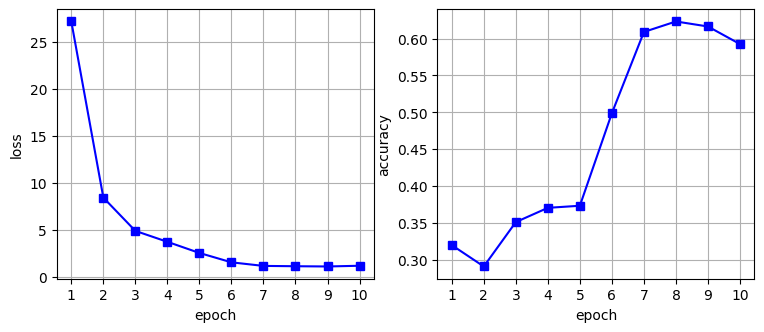

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history["loss"]) + 1)
ax = axes[0]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(xx)
ax.plot(xx, H.history["loss"], color="b", marker="s")
ax = axes[1]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(xx)
ax.plot(xx, H.history["accuracy"], color="b", marker="s");

In [28]:
score = M.evaluate(test_dataset, verbose=0)
print(f"Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}")

Loss: 1.092
Precisión: 60.0%


## 1.2. MLP Architecture

Resultados:
- Test: Accuracy 62%
- Validation: Accuracy 63.63%

In [39]:
def build_model(hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=input_dim))
    for L in range(hp.Int("num_layers", 1, 3)):
        M.add(
            keras.layers.Dense(
                units=hp.Int(f"units_{L}", min_value=400, max_value=800, step=100),
                activation="relu",
            )
        )
    M.add(keras.layers.Dense(5, activation="softmax"))
    M.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return M

In [40]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="/tmp",
    project_name="DIAB_ARC",
)

In [41]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 400, 'max_value': 800, 'step': 100, 'sampling': 'linear'}


In [42]:
tuner.search(train_dataset, batch_size=16, epochs=10, validation_data=val_dataset)

Trial 20 Complete [00h 01m 42s]
val_accuracy: 0.6363636255264282

Best val_accuracy So Far: 0.6363636255264282
Total elapsed time: 00h 11m 30s


In [43]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/DIAB_ARC
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 19 summary
Hyperparameters:
num_layers: 2
units_0: 700
units_1: 400
units_2: 700
Score: 0.6363636255264282


In [44]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(test_dataset, verbose=0)
print(f"Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 1.159
Precisión: 62.00%


In [45]:
M = build_model(tuner.get_best_hyperparameters(1)[0])
H = M.fit(train_dataset.concatenate(val_dataset), batch_size=16, epochs=10, verbose=0)

In [46]:
score = M.evaluate(test_dataset, verbose=0)
print(f"Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}")

Loss: 1.137
Precisión: 60.0%


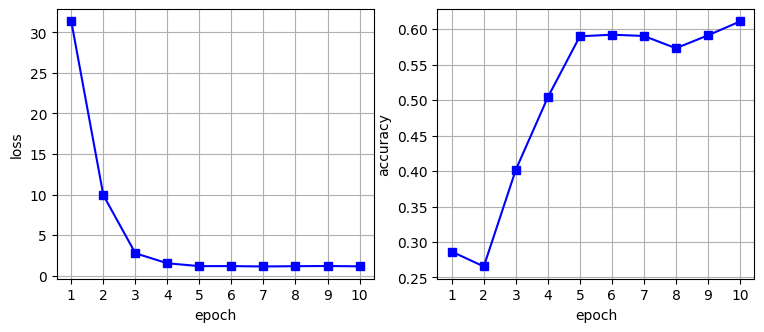

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history["loss"]) + 1)
ax = axes[0]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(xx)
ax.plot(xx, H.history["loss"], color="b", marker="s")
ax = axes[1]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(xx)
ax.plot(xx, H.history["accuracy"], color="b", marker="s")